<img src="https://bonsai-producciones.com/wp-content/uploads/2020/04/logo-CUNEF.png" width="400" height="200">

# <p style="text-align:center"> <font color='darkorange'>**FINAL_ST_HW - TOSCOS**</font>
### <p style="text-align:center"> **Técnicas de predicción: series temporales**</strong><br />
    
<p style="text-align:center"> <font color='grey'>Mario Sabater Pascual - <u>mario.sabater@cunef.edu </u></font>

## <font color='black'>**Introducción**</font>


En el fichero datos.csv se encuentran las ventas (Sales) de las diez tiendas de la cadena de supermercados TOSCOS. Son datos diarios y además de las ventas tiene información sobre el número de clientes que han entrado en cada tienda (Customers), si está abierta (Open), si tienes promociones (Promo), si es fiesta (StateHoliday) y si es día lectivo (SchoolHoliday).

Las tiendas están divididas en 3 zonas (1, 2 y 3) y tienen 3, 3 y 4 tiendas respectivamente.

**En este notebook graficaremos y predeciremos las ventas totales semanales**

 - [Carga de librerías](#0)
 - [Carga y tratamiento de datos](#1)
 - [Gráfica ventas totales semanales](#2)
 - [Predicción ventas totales semanales](#3)
     - [Neural Prophet](#3.1)
     - [Grid Search CV](#3.2)
     - [ETS](#3.3)     
 - [Mejor Modelo y exportación de los datos](#4)

##  <a name="0"> **Carga de librerías**</a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

##  <a name="1"> **Carga y tratamiento de datos**</a>

In [2]:
datos = pd.read_csv('../data/datos.csv')
datos = datos.sort_values(by=['Date', 'Store'])
datos.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
9226,T1a,2,2013-01-01,0,0,0,0,a,1
9227,T1b,2,2013-01-01,0,0,0,0,a,1
9228,T1c,2,2013-01-01,0,0,0,0,a,1


In [3]:
#Transformación columna Date.
datos['Date'] = pd.to_datetime(datos['Date'], format=('%Y-%m-%d'))

In [4]:
datos.set_index('Date', inplace=True)

Para graficar los datos totales semanales, debemos sumar las ventas diarias de cada una de las tiendas y de la semana. Dejaremos el último día de la semana como indicador de esta.

Al igual que en el notebook anterior, inlcuimos también otras columnas como Customers, Open y Promo porque creemos que en un futuro pueden ser útiles a la hora de predecir.

In [5]:
datos_totales_diarios = datos.groupby('Date')['Sales', 'Customers', 'Open', 'Promo'].sum().reset_index()
datos_totales_diarios.set_index('Date', inplace=True)
datos_totales_semanales = datos_totales_diarios.resample('w').sum()
datos_totales_semanales.head(3)

,Sales,Customers,Open,Promo
Date,,,,
2013-01-06,227030,27671,36,0
2013-01-13,395390,45616,54,50
2013-01-20,305576,38441,54,0


In [6]:
len(datos_totales_semanales)

135

In [7]:
datos_totales_semanales.tail(3)

,Sales,Customers,Open,Promo
Date,,,,
2015-07-19,501709,51321,60,50
2015-07-26,389502,43589,60,0
2015-08-02,432467,41919,50,50


In [8]:
datos_totales_semanales['Promo'].unique()

array([ 0, 50, 46, 45])

De la misma forma que vimos en el notebook anterior con los datos diarios, observamos que en la semana de rebajas, estas duran de 4.5 días (algunas tiendas tendrán 4 dias y otras 5) a 5 días. Por este motivo señalaremos en nuestro gravico aquellas semanas en las que la columna Promo indique un valor de 45 o más.

##  <a name="2"> **Gráfica ventas totales semanales**</a>

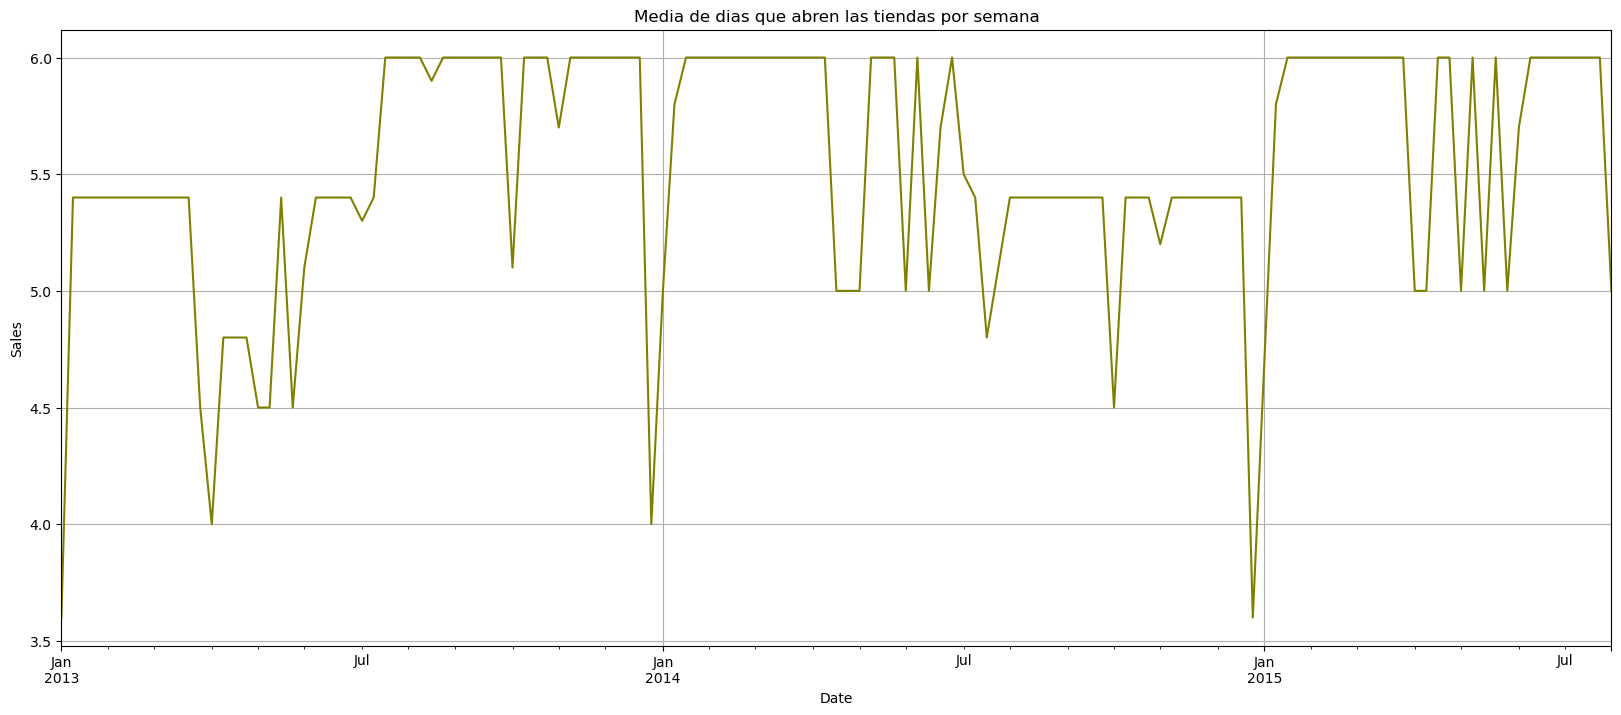

In [9]:
#Observacion de media de tiendas abiertas por semana. (6 es el total)
datos_totales_semanales['Open'] = datos_totales_semanales['Open']/10
fig, ax = plt.subplots(figsize=(20,8))
datos_totales_semanales['Open'].plot(title="Media de dias que abren las tiendas por semana", color = 'olive',
                                    grid=True,xlabel="Date", ylabel="Sales", ax=ax)


plt.show()

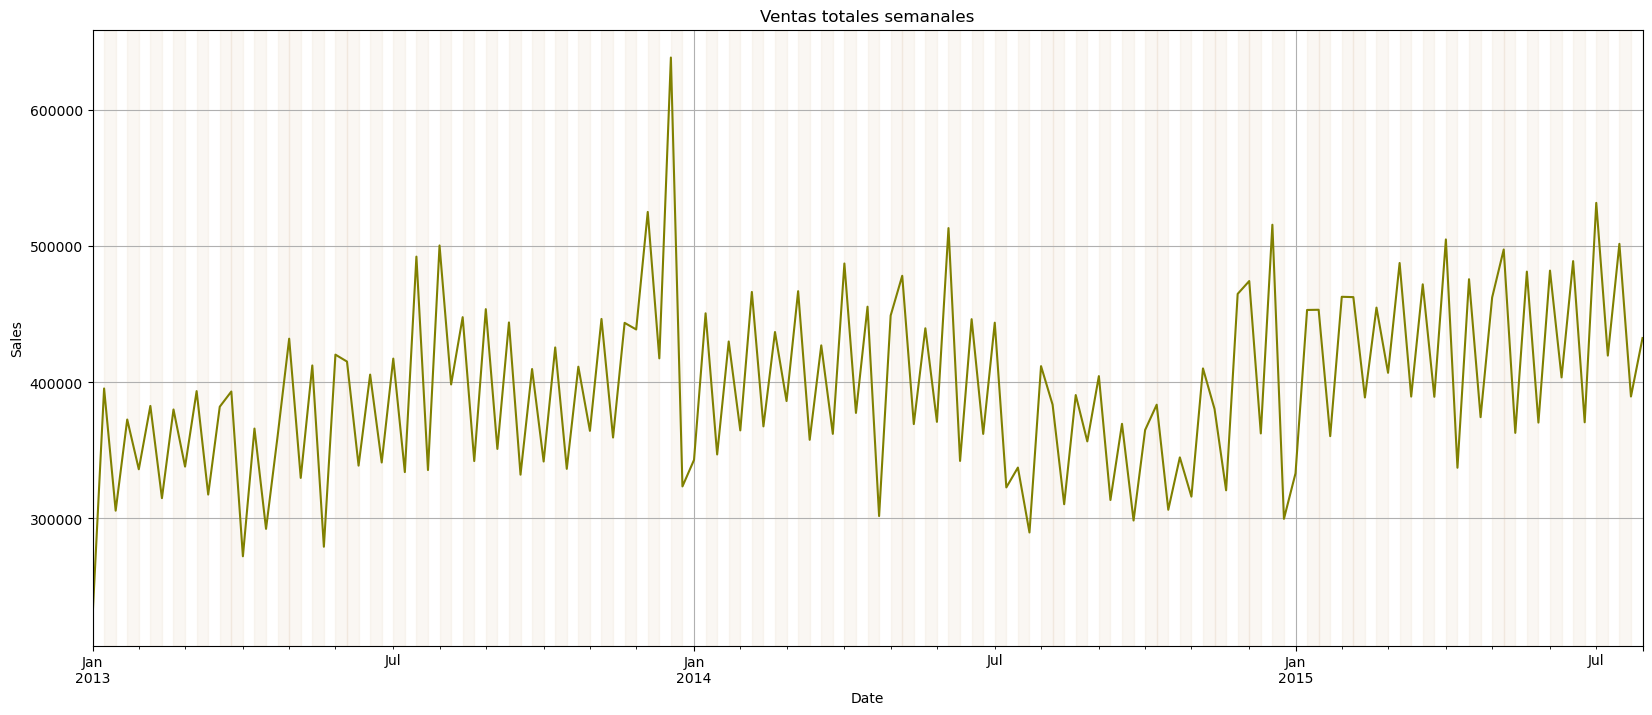

In [10]:
#Creamos una mask para marcar el fondo cuando en al menos 4.5 dias de la semana de media haya rebajas.
mask = datos_totales_semanales['Promo'] >= 45

fig, ax = plt.subplots(figsize=(20,8))
datos_totales_semanales['Sales'].plot(title="Ventas totales semanales", color = 'olive',
                                    grid=True,xlabel="Date", ylabel="Sales", ax=ax)

# create the regions where sales are 9 or more
for index, row in datos_totales_semanales[mask].iterrows():
    ax.axvspan(index, index+pd.Timedelta('1W'), color='tan', alpha=0.1)

plt.show()

##  <a name="3"> **Predicción ventas totales semanales**</a>

###  <a name="3.0"> **Separación train-test y visualización**</a>

In [11]:
datos_sem = datos_totales_semanales['Sales']

In [12]:
datos_sem = datos_sem.reset_index(drop=False)
datos_sem.columns = ['ds', 'y']
datos_sem.head()

,ds,y
0,2013-01-06,227030
1,2013-01-13,395390
2,2013-01-20,305576
3,2013-01-27,372581
4,2013-02-03,335998


In [13]:
N=15; Freq='W-SUN'

train = datos_sem.iloc[:-N]
test  = datos_sem.iloc[-N:]

print(train.shape, test.shape)
print(train.tail(1),'\n',test.head(1))

(120, 2) (15, 2)
            ds       y
119 2015-04-19  475696 
             ds       y
120 2015-04-26  374298


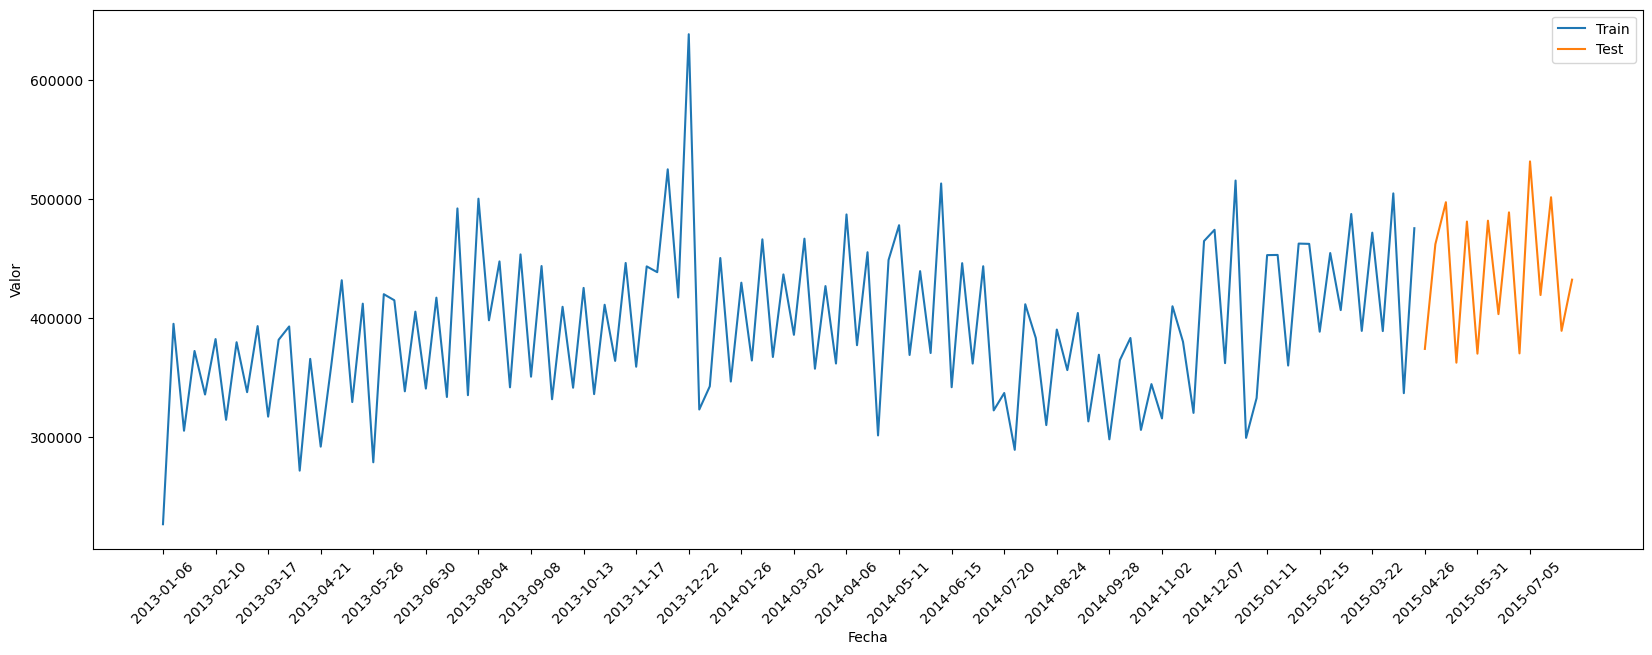

In [14]:
plt.figure(figsize=(20,7))
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], test['y'], label='Test')

plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()

x_dates = train['ds'].append(test['ds']).sort_values().unique()
tick_spacing = 5
x_ticks = x_dates[::tick_spacing]

plt.xticks(x_ticks, rotation=45)
plt.show()

###  <a name="3.1"> **Neural Prophet**</a>

In [15]:
from neuralprophet import NeuralProphet, set_random_seed 
set_random_seed(0)

In [16]:
def mean_absolute_percentage_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  if np.any(y_true==0)==True:
    print('Erro: y_true contêm zeros!')
    return np.inf
  else:
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
model = NeuralProphet(
    growth="linear",    # Determine trend types: 'linear', 'discontinuous', 'off'
    changepoints=None,  # list of dates that may include change points (None->automatic)
    n_changepoints=10,
    changepoints_range=0.8,
    trend_reg=0,
    trend_reg_threshold=False,
    trend_global_local = 'local',
    yearly_seasonality=9,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode="additive",
    seasonality_reg=0,
    n_forecasts=1,
    n_lags=0,
    num_hidden_layers=30,
    d_hidden=190,      # Dimension of hidden layers of AR-Net
    learning_rate=0.1,
    epochs=300,  
    batch_size = 32,
    loss_func="Huber",
    normalize="minmax",   # Type of normalization ('minmax', 'standardize', 'soft', 'off')
    impute_missing=True
)

CPU times: user 466 µs, sys: 123 µs, total: 589 µs
Wall time: 531 µs


In [18]:
metrics = model.fit(train, freq=Freq)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.167% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-SUN
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: 0it [00:00, ?it/s]

In [19]:
future = model.make_future_dataframe(train, periods=len(test), n_historic_predictions=len(train)) 
forecast = model.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.167% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-SUN
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.259% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-SUN
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.259% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-SUN


Predicting: 4it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


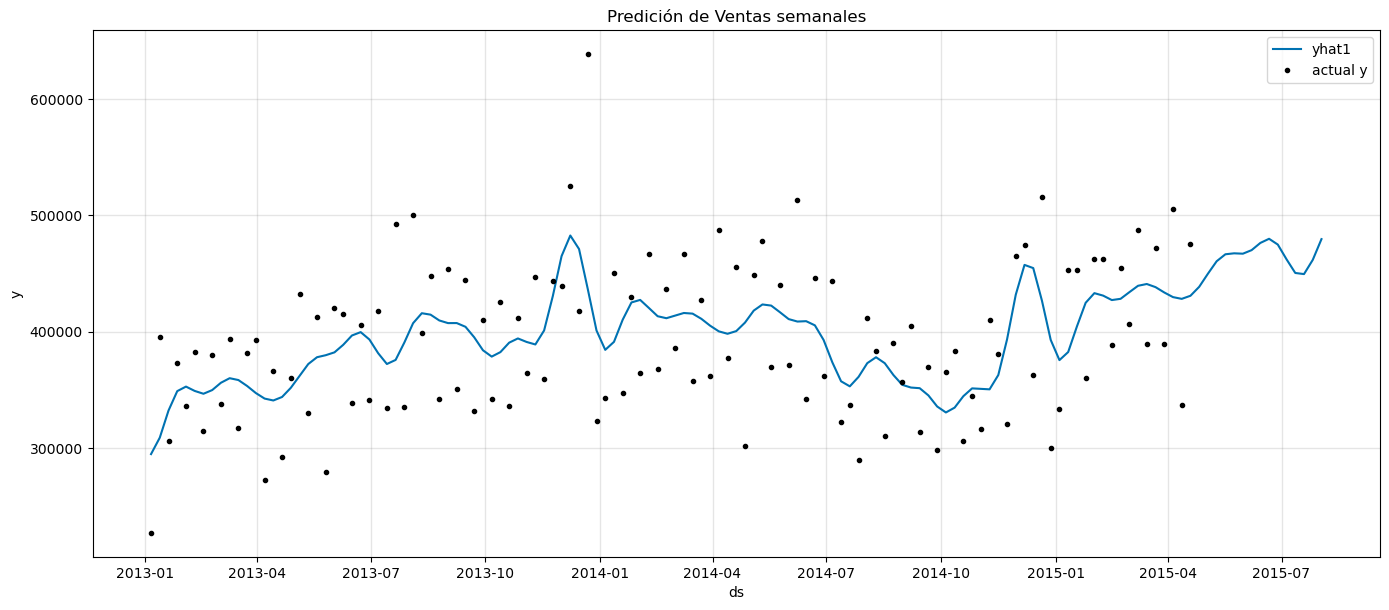

In [20]:
model.plot(forecast,figsize=(14,6))
plt.title('Predición de Ventas semanales')
plt.show()

In [21]:
y_true = test['y'].values
y_pred = forecast['yhat1'][-N:].values
mae  = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MAE:  {mae:.2f} u.m')
print(f'MAPE: {mape:.2f}%')
print(f'r2: {r2:.4f}')

MAE:  53218.13 u.m
MAPE: 13.05%
r2: -0.2620


###  <a name="3.2"> **Grid Search CV**</a>

In [22]:
# Series:
from statsmodels.tsa.seasonal import STL
from sktime.utils.plotting import plot_series
from datetime import timedelta
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

In [23]:
train, test = (datos_totales_semanales['Sales'].astype('float64').asfreq('W-SUN')[:120], 
               datos_totales_semanales['Sales'].astype('float64').asfreq('W-SUN')[120:])

In [24]:
# GridSearch Cross Validation
# Inputs: transformaciones y modelos
pipe = TransformedTargetForecaster(steps=[
    ("forecaster", NaiveForecaster())])
# Defenir el CV
cv = ExpandingWindowSplitter(
    initial_window=104,
     step_length=1,
     start_with_window=True,
     fh=16)
# definir los modelos y los parametros (GRID)
gscv = ForecastingGridSearchCV(
     forecaster=pipe,
    param_grid=[{
         "forecaster": [NaiveForecaster(sp=52)],
         "forecaster__strategy": ["drift", "last", "mean"],
     },
      {
      "forecaster": [ExponentialSmoothing(sp=52)],
      "forecaster__trend": ["add", "mul"],
      "forecaster__damped_trend": [True,False],
      "forecaster__seasonal": ["add", "mul"],
      },
       {
        "forecaster": [ThetaForecaster(sp=52)],
       },
     ],
     cv=cv,
     verbose=1,
     n_jobs=-1)

In [25]:
# Entrenamos:
gscv.fit(train) 

Fitting 1 folds for each of 12 candidates, totalling 12 fits


WARNING - (py.warnings._showwarnmsg) - /Users/mariosabater/opt/anaconda3/envs/pred_final/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(

WARNING - (py.warnings._showwarnmsg) - /Users/mariosabater/opt/anaconda3/envs/pred_final/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(



ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=16, initial_window=104),
                        forecaster=TransformedTargetForecaster(steps=[('forecaster',
                                                                       NaiveForecaster())]),
                        n_jobs=-1,
                        param_grid=[{'forecaster': [NaiveForecaster(sp=52)],
                                     'forecaster__strategy': ['drift', 'last',
                                                              'mean']},
                                    {'forecaster': [ExponentialSmoothing(sp=52)],
                                     'forecaster__damped_trend': [True, False],
                                     'forecaster__seasonal': ['add', 'mul'],
                                     'forecaster__trend': ['add', 'mul']},
                                    {'forecaster': [ThetaForecaster(sp=52)]}],
                        verbose=1)

In [41]:
# Mejor modelo:
print(gscv.best_forecaster_)

TransformedTargetForecaster(steps=[('forecaster',
                                    ExponentialSmoothing(damped_trend=True,
                                                         seasonal='add', sp=52,
                                                         trend='mul'))])


In [27]:
# Métricas:
gscv.best_score_

0.036213230727334504

In [28]:
predictions = gscv.predict(fh=list(range(1, 16)))
r2 = r2_score(test, predictions)
MAPE = mean_absolute_percentage_error(test, predictions)
print(f'R-squared: {r2}')
print(f'MAPE: {MAPE}')

R-squared: 0.2296841544067364
MAPE: 0.0871014379024598


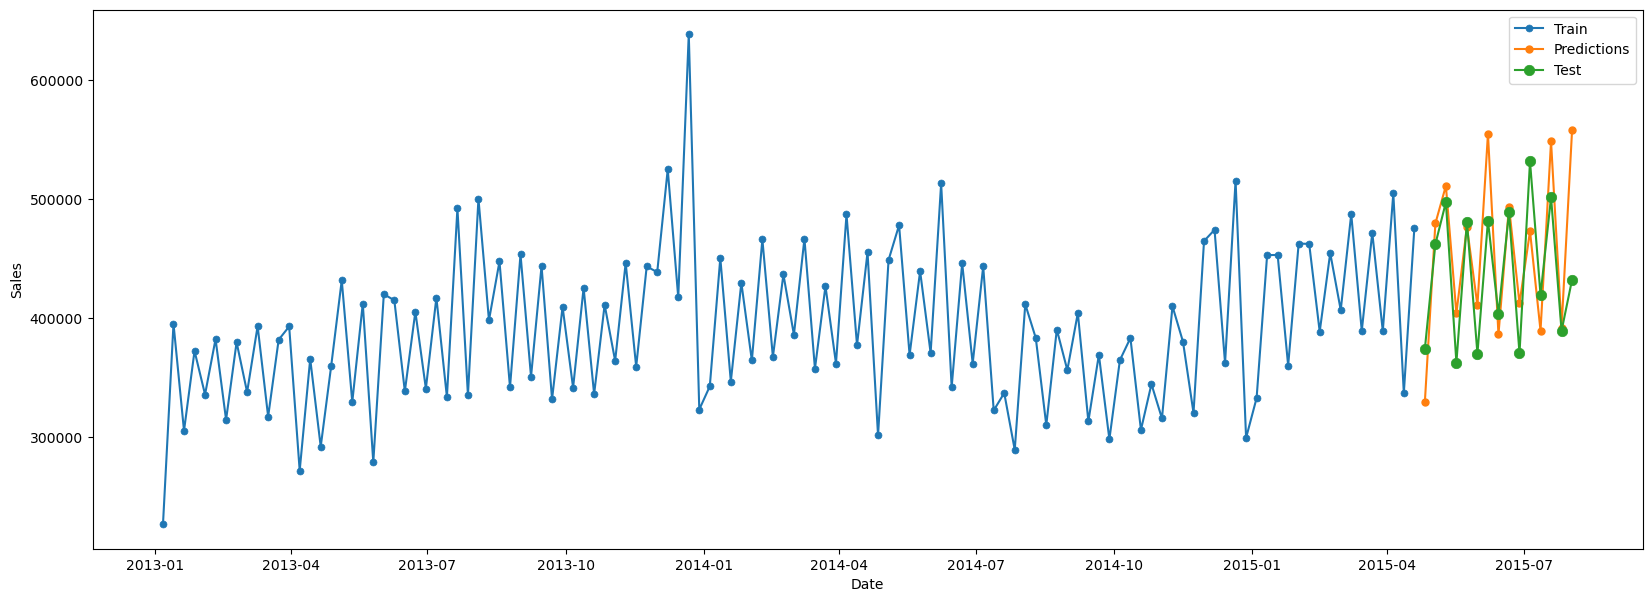

In [29]:
plt.figure(figsize=(20,7))
plt.plot(train, marker='o', label='Train', markeredgewidth=0.5, markersize=5)
plt.plot(predictions, marker='o', label='Predictions', markeredgewidth=1,markersize=5)
plt.plot(test, marker='o', label='Test', markeredgewidth=0.5, markersize=7.5)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

###  <a name="3.3"> **ETS**</a>

In [30]:
error = ['add', 'mul']
trend = ['add', 'mul', None]
damped_trend = [True, False]
seasonal = ['add', 'mul', None]

for e in error:
    for t in trend:
        for d in damped_trend:
            if d and t==None:
                continue
            for s in seasonal:
                print('Error: ', e, ', Tendencia: ', t, ', Damped: ', d, ', Estacionalidad: ', s)
                ETS_model_weekly = AutoETS(error=e, trend=t, damped_trend=d, sp=52, 
                                           seasonal=s, auto=False, n_jobs=-1)
                ETS_model_weekly.fit(train)
                preds = ETS_model_weekly.predict(fh=list(range(1, 16)))
                mape = mean_absolute_percentage_error(test, preds)
                print(f'MAPE: {mape}')
                r2 = r2_score(test, preds)
                print(f'R-squared: {r2}', '\n')

Error:  add , Tendencia:  add , Damped:  True , Estacionalidad:  add
MAPE: 0.09241853070306562
R-squared: 0.324198224428604 

Error:  add , Tendencia:  add , Damped:  True , Estacionalidad:  mul
MAPE: 0.10202239358996024
R-squared: 0.22025349787073167 

Error:  add , Tendencia:  add , Damped:  True , Estacionalidad:  None
MAPE: 0.11828828400941041
R-squared: 0.0046302969395346505 

Error:  add , Tendencia:  add , Damped:  False , Estacionalidad:  add
MAPE: 0.09578124219546887
R-squared: 0.2451337170586625 

Error:  add , Tendencia:  add , Damped:  False , Estacionalidad:  mul
MAPE: 0.10530564386002846
R-squared: 0.06660245028087175 

Error:  add , Tendencia:  add , Damped:  False , Estacionalidad:  None
MAPE: 0.1401307309198285
R-squared: -0.5086574274476001 

Error:  add , Tendencia:  mul , Damped:  True , Estacionalidad:  add
MAPE: 0.09016015877316479
R-squared: 0.3281448858914867 

Error:  add , Tendencia:  mul , Damped:  True , Estacionalidad:  mul
MAPE: 0.10380711397320995
R-squar

In [31]:
best_ETS = AutoETS(error="add", trend=None, damped_trend=False, 
                               seasonal="add",auto=False,sp=52, n_jobs=-1)
best_ETS.fit(train)
preds = best_ETS.predict(fh=list(range(1, 16)))

mape = mean_absolute_percentage_error(test, preds)
print(f'MAPE: {mape}')

r2 = r2_score(test, preds)
print(f'R-squared: {r2}', '\n')

MAPE: 0.09110767848186394
R-squared: 0.34007991360896916 



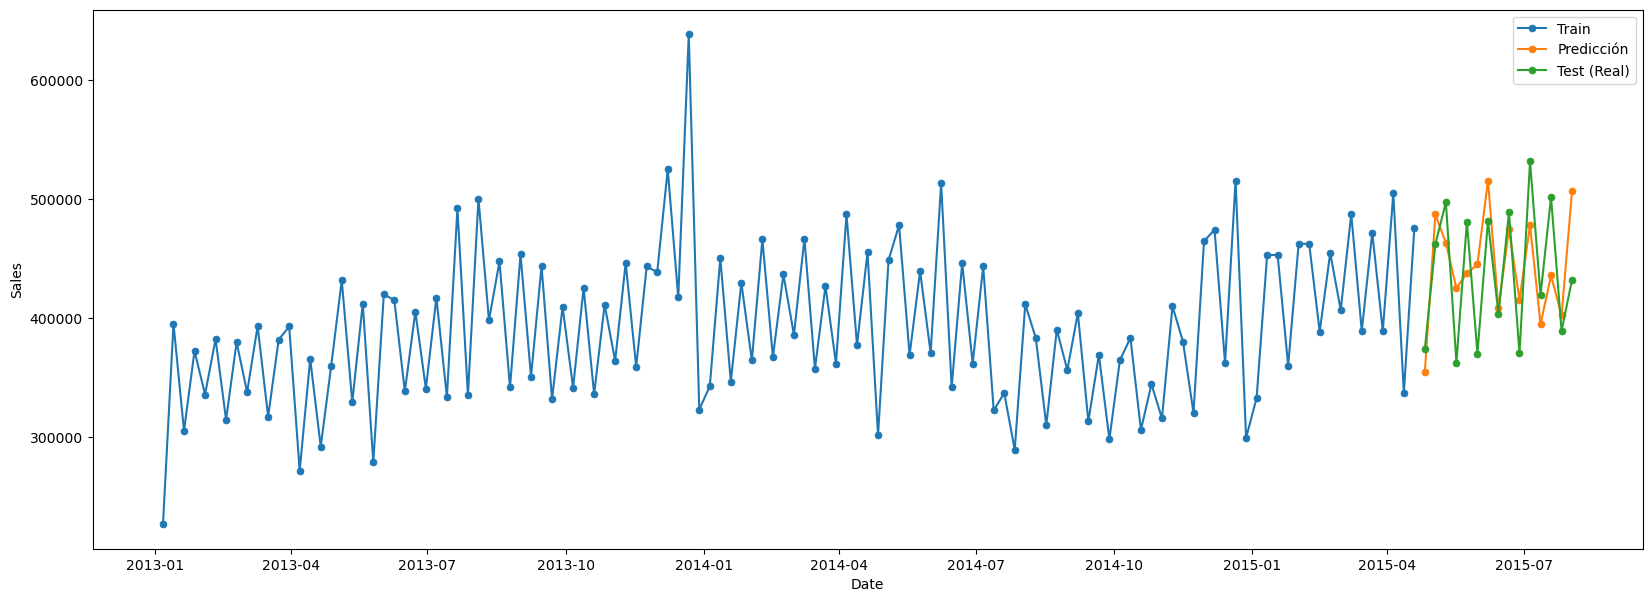

In [43]:
plt.figure(figsize=(20,7))
plt.plot(train, marker='o', label='Train', markeredgewidth=0.5, markersize=5)
plt.plot(preds, marker='o', label='Predicción', markeredgewidth=0.5, markersize=5)
plt.plot(test, marker='o', label='Test (Real)', markeredgewidth=0.5, markersize=5)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

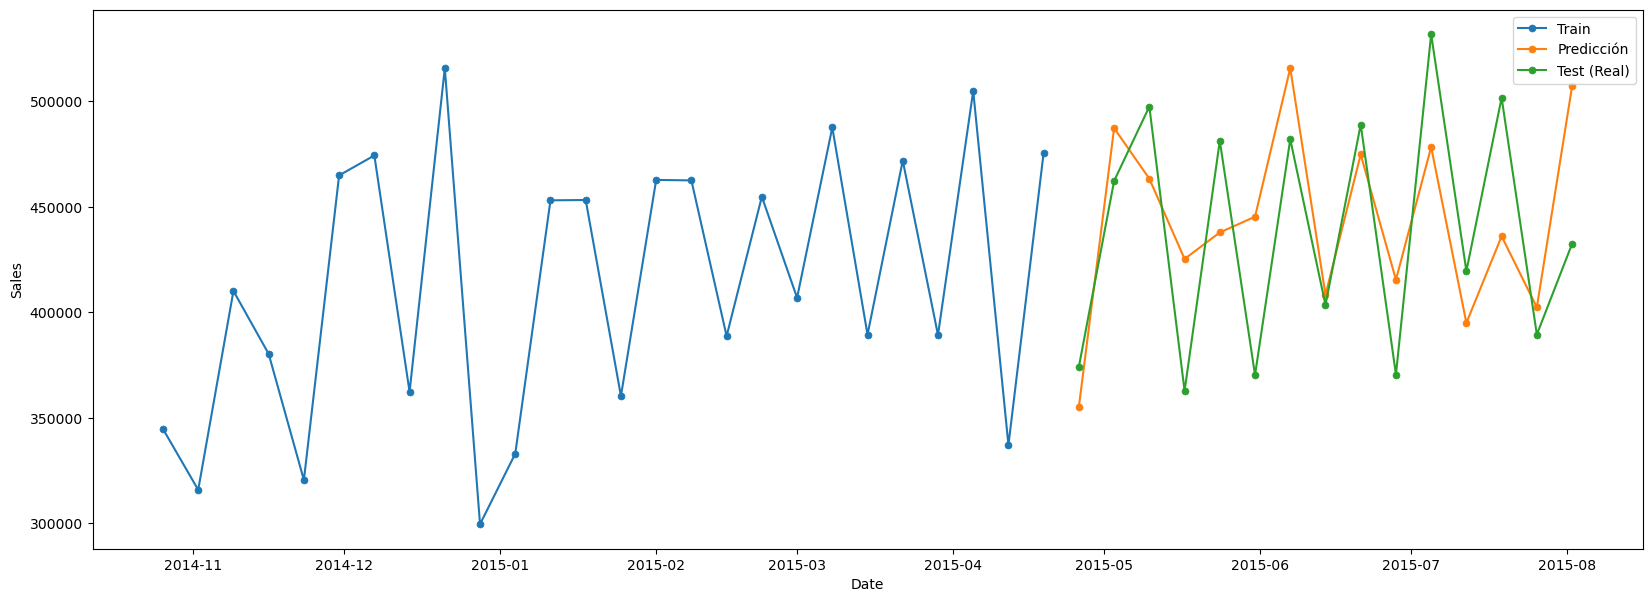

In [44]:
plt.figure(figsize=(20,7))
plt.plot(train.tail(26), marker='o', label='Train', markeredgewidth=0.5, markersize=5)
plt.plot(preds, marker='o', label='Predicción', markeredgewidth=0.5, markersize=5)
plt.plot(test, marker='o', label='Test (Real)', markeredgewidth=0.5, markersize=5)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

##  <a name="4"> **Mejor Modelo y exportación de los datos**</a>

In [34]:
datos_totales_semanales = datos_totales_semanales['Sales'].astype('float64').asfreq('W-SUN')

In [35]:
datos_totales_semanales

Date
2013-01-06    227030.0
2013-01-13    395390.0
2013-01-20    305576.0
2013-01-27    372581.0
2013-02-03    335998.0
                ...   
2015-07-05    531819.0
2015-07-12    419561.0
2015-07-19    501709.0
2015-07-26    389502.0
2015-08-02    432467.0
Freq: W-SUN, Name: Sales, Length: 135, dtype: float64

In [36]:
best_ETS.fit(datos_totales_semanales)

AutoETS(n_jobs=-1, seasonal='add', sp=52)

In [37]:
predictions = best_ETS.predict(fh=list(range(1, 7)))  
print(predictions)

2015-08-09    466233.776631
2015-08-16    422272.153736
2015-08-23    466366.361005
2015-08-30    466870.921916
2015-09-06    455514.060637
2015-09-13    427637.925952
Freq: W-SUN, dtype: float64


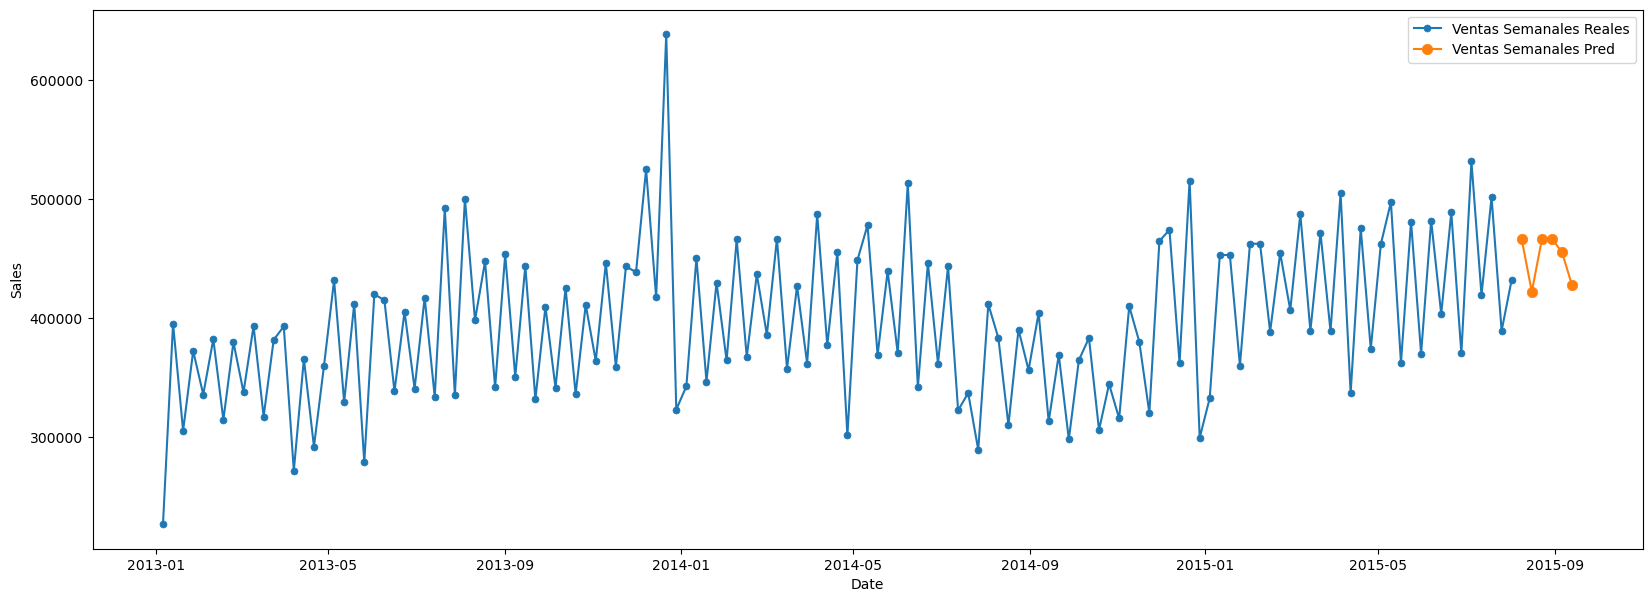

In [38]:
plt.figure(figsize=(20,7))
plt.plot(datos_totales_semanales, marker='o', label='Ventas Semanales Reales',
         markeredgewidth=0.5, markersize=5)

plt.plot(predictions, marker='o', label='Ventas Semanales Pred', 
         markeredgewidth=0.5,markersize=7.5)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

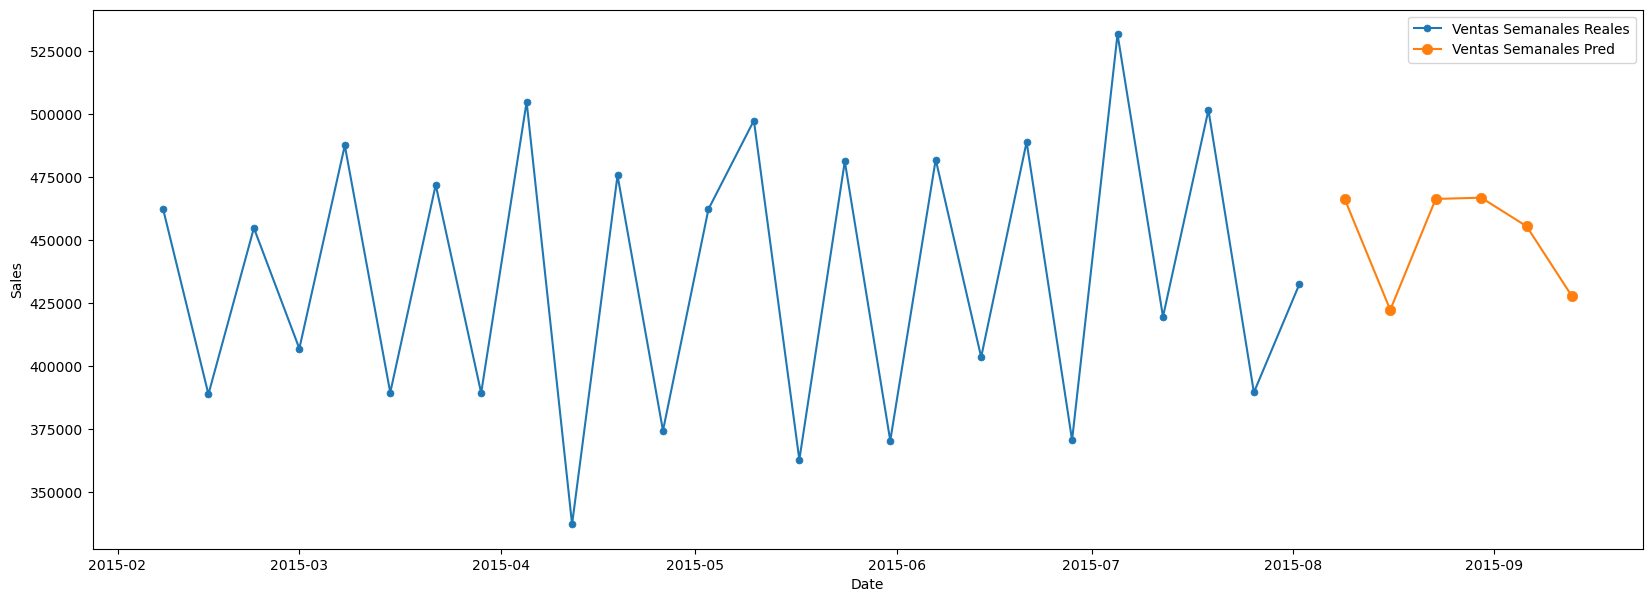

In [39]:
plt.figure(figsize=(20,7))
plt.plot(datos_totales_semanales.tail(26), marker='o', label='Ventas Semanales Reales',
         markeredgewidth=0.5, markersize=5)

plt.plot(predictions, marker='o', label='Ventas Semanales Pred', 
         markeredgewidth=0.5,markersize=7.5)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [40]:
predictions.to_csv('../data/prediccion_semanal.csv', header=False,  index=False)

/Users/mariosabater/opt/anaconda3/envs/pred_final/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/mariosabater/opt/anaconda3/envs/pred_final/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/mariosabater/opt/anaconda3/envs/pred_final/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/mariosabater/opt/anaconda3/envs/pred_final/lib/python3.8/site-packages/sktime/forecasting/naive.py:169: UserWarning: For the `drift` strategy, the `sp` value will be ignored.
  warn("For the `drift` strategy, the `sp` value will be ignored.")
/Users/mariosabater/opt/anaconda3/envs/pred_final/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: Con